### NLI

A large annotated corpus for learning natural language inference by [Bowman et al.](https://arxiv.org/pdf/1508.05326v1.pdf)

In [1]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [2]:
ls entailment/data

glove.6B.zip  labels.npz  labels.txt  labels_dev.npz  snli_1.0.zip  vocab.txt


#### Dataset reader

The dataset is too large to fit into the memory, we will need to build a dataset reader. 

We will include the text preprocessor into the python generator.

In [61]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '[START] ' + w + ' [END]'
        return w

In [62]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
import tensorflow as tf
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'
dev_file_name = 'snli_1.0/snli_1.0_dev.txt'

def read_zip_csv(filename):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                #print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    #for line in tqdm(f):
                    for line in f:
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data = np.array(terms)[idx]
                                #print("d1=", data[1])
                                lbl, hyp, evi = data
                                data = [lbl, preprocess(hyp), preprocess(evi)]
                                yield data


n_features = 3
def get_dataset():
    generator = lambda: read_zip_csv(zip_file_name)
    return tf.data.Dataset.from_generator(
        generator, (tf.string), (n_features, ), ())


def read_zip_csv_dev(filename):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if dev_file_name in info.filename:
                # read the file
                #print("Reading lines from file {}".format(dev_file_name))
                with io.TextIOWrapper(z.open(dev_file_name), encoding="utf-8") as f:
                    #for line in tqdm(f):
                    for line in f:
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data = np.array(terms)[idx]
                                #print("d1=", data[1])
                                lbl, hyp, evi = data
                                data = [lbl, preprocess(hyp), preprocess(evi)]
                                yield data


n_features = 3
def get_dataset_dev():
    generator = lambda: read_zip_csv_dev(zip_file_name)
    return tf.data.Dataset.from_generator(
        generator, (tf.string), (n_features, ), ())

In [63]:
for d in get_dataset().take(5):
    print(d)

tf.Tensor(
[b'neutral'
 b'[START] a person on a horse jumps over a broken down airplane . [END]'
 b'[START] a person is training his horse for a competition . [END]'], shape=(3,), dtype=string)
tf.Tensor(
[b'contradiction'
 b'[START] a person on a horse jumps over a broken down airplane . [END]'
 b'[START] a person is at a diner , ordering an omelette . [END]'], shape=(3,), dtype=string)
tf.Tensor(
[b'entailment'
 b'[START] a person on a horse jumps over a broken down airplane . [END]'
 b'[START] a person is outdoors , on a horse . [END]'], shape=(3,), dtype=string)
tf.Tensor(
[b'neutral' b'[START] children smiling and waving at camera [END]'
 b'[START] they are smiling at their parents [END]'], shape=(3,), dtype=string)
tf.Tensor(
[b'entailment' b'[START] children smiling and waving at camera [END]'
 b'[START] there are children present [END]'], shape=(3,), dtype=string)


In [64]:
raw_ds = get_dataset()
dev_ds = get_dataset_dev()

In [65]:
next(iter(raw_ds)).numpy()

array([b'neutral',
       b'[START] a person on a horse jumps over a broken down airplane . [END]',
       b'[START] a person is training his horse for a competition . [END]'],
      dtype=object)

In [66]:
next(iter(dev_ds)).numpy()

array([b'neutral',
       b'[START] two women are embracing while holding to go packages . [END]',
       b'[START] the sisters are hugging goodbye while holding to go packages after just eating lunch . [END]'],
      dtype=object)

The texts are available in two columns, the hypothesis and the evidence. We will need to concatenate them if we wish to send them to a tokenizer.

In [67]:
mapped_ds = raw_ds.map(lambda x: tf.strings.join([x[1], x[2]], separator=" "))

We need tensorflow_text for using pre built bert tokenizers.

The tensorflow text needs tensorflow 2.5.0, so we will need to install the tensorflow-gpu version 2.5.0 as well, when using the Deep learning AMI in AWS.

In [9]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

The bert_vocab_from_dataset can efficiently handle processing of the texts in the training dataset, as we send them in to the vocab builder batch by batch.

In [68]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [69]:
%%time
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    mapped_ds.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 4min 25s, sys: 23.9 s, total: 4min 49s
Wall time: 3min 19s


In [71]:
print(pt_vocab[:10])
print(pt_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', '[', ']']
['yellow', 'has', 'riding', 'ball', 'out', 'brown', 'hat', 'next', 'into', 'building']


In [72]:
def write_vocab_file(filepath, vocab):
    print("Saving vocab file to {}".format(filepath))
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [73]:
vocab_file_out = 'entailment/data/vocab.txt'
write_vocab_file(vocab_file_out, pt_vocab)

Saving vocab file to entailment/data/vocab.txt


In [74]:
!wc -l entailment/data/vocab.txt

7880 entailment/data/vocab.txt


Note: our basic tokenizer had 14863 words only from 200K documents. We have restricted the vocab to only 8K here.

Tokenizing and padding see code [here](https://www.tensorflow.org/text/guide/bert_preprocessing_guide) and [here](https://github.com/tensorflow/tensorflow/issues/34793)

When not using batching (lazy loading), we would first tokenize all sentences and the add padding to them. This allowed us to know the max length of the sequences for each of the hypothesis and evidences. (it was 84 and 46 respectively for 200K samples)
We could still do that, however, we would restrict to a fixed max length for now.

TODO: look to go to different max lengths for hypothesis and evidence.

This is the step where we dould generate the on hot encoded labels as well.

In [193]:
dev_labels = []
for d in dev_ds:
    dev_labels.append(d[0].numpy().decode('utf-8'))

In [194]:
labels = []
for d in raw_ds:
    labels.append(d[0].numpy().decode('utf-8'))

In [199]:
len(labels)

549367

In [200]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)
dev_labels_enc = le.transform(dev_labels)
#labels_enc
onehot_labels = np.zeros(shape=(len(labels_enc),3))
onehot_labels_dev = np.zeros(shape=(len(dev_labels_enc),3))
for idx, val in enumerate(labels_enc):
    onehot_labels[idx][val]=1
for idx, val in enumerate(dev_labels_enc):
    onehot_labels_dev[idx][val]=1   
print("A peek a the reshaped labels:")
print(onehot_labels[:5])
print(onehot_labels_dev[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(onehot_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [201]:
outfile = "entailment/data/labels.npz"
np.savez(outfile, onehot_labels)
outfile_dev = "entailment/data/labels_dev.npz"
np.savez(outfile_dev, onehot_labels_dev)

In [41]:
ls entailment/data/

glove.6B.zip  labels.npz  labels.txt  snli_1.0.zip  vocab.txt


In [17]:
npzfile = np.load("entailment/data/labels.npz")
npzfile.files

['arr_0']

In [18]:
npzfile_dev = np.load("entailment/data/labels_dev.npz")
npzfile_dev.files

['arr_0']

In [19]:
print(npzfile['arr_0'].shape)
onehot_labels = npzfile['arr_0']

(549367, 3)


In [20]:
print(npzfile_dev['arr_0'].shape)
onehot_labels_dev = npzfile_dev['arr_0']

(9842, 3)


In [21]:
print(len(onehot_labels))
onehot_labels[:5]

549367


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [22]:
print(len(onehot_labels_dev))
onehot_labels_dev[:5]

9842


array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
onehot_labels.shape
print(type(onehot_labels))

<class 'numpy.ndarray'>


In [279]:
ls entailment/data/

glove.6B.zip  labels.npz  labels.txt  snli_1.0.zip  vocab.txt


In [25]:
lbls = tf.reshape(tf.convert_to_tensor(onehot_labels, dtype=tf.int32), (onehot_labels.shape))
lbls_ds = tf.data.Dataset.from_tensor_slices(lbls)
raw_ds_enc_labls = tf.data.Dataset.zip((raw_ds, lbls_ds))
print(raw_ds_enc_labls.element_spec)

(TensorSpec(shape=(3,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


In [26]:
lbls_dev = tf.reshape(tf.convert_to_tensor(onehot_labels_dev, dtype=tf.int32), (onehot_labels_dev.shape))
lbls_ds_dev = tf.data.Dataset.from_tensor_slices(lbls_dev)
raw_ds_enc_labls_dev = tf.data.Dataset.zip((dev_ds, lbls_ds_dev))
print(raw_ds_enc_labls_dev.element_spec)

(TensorSpec(shape=(3,), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))


In [55]:
for d in raw_ds.batch(1).take(1):
    print(d)

tf.Tensor(
[[b'neutral'
  b'<start> a person on a horse jumps over a broken down airplane . <end>'
  b'<start> a person is training his horse for a competition . <end>']], shape=(1, 3), dtype=string)


##### Test the tokenizer

In [79]:
token_batch = pt_tokenizer.tokenize("[START] This is a test [END]")
print(token_batch)
pt_tokenizer.detokenize(token_batch)

<tf.RaggedTensor [[[1], [39], [1], [253], [42], [12], [2042], [1], [38], [1]]]>


<tf.RaggedTensor [[[b'[UNK]'], [b'start'], [b'[UNK]'], [b'this'], [b'is'], [b'a'], [b'test'], [b'[UNK]'], [b'end'], [b'[UNK]']]]>

In [75]:
import tensorflow_text as text
bert_tokenizer_params=dict(lower_case=True)
vocab_file_out = 'entailment/data/vocab.txt'
pt_tokenizer = text.BertTokenizer(vocab_file_out, **bert_tokenizer_params)

In [76]:
for x in raw_ds.take(10):
    print(x[1])
    token_batch = pt_tokenizer.tokenize(x[1])[0]
    print(token_batch)
    print(pt_tokenizer.detokenize(token_batch))

tf.Tensor(b'[START] a person on a horse jumps over a broken down airplane . [END]', shape=(), dtype=string)
<tf.RaggedTensor [[1], [39], [1], [12], [78], [44], [12], [232], [241], [115], [12], [1199], [74], [843], [8], [1], [38], [1]]>
<tf.RaggedTensor [[b'[UNK]'], [b'start'], [b'[UNK]'], [b'a'], [b'person'], [b'on'], [b'a'], [b'horse'], [b'jumps'], [b'over'], [b'a'], [b'broken'], [b'down'], [b'airplane'], [b'.'], [b'[UNK]'], [b'end'], [b'[UNK]']]>
tf.Tensor(b'[START] a person on a horse jumps over a broken down airplane . [END]', shape=(), dtype=string)
<tf.RaggedTensor [[1], [39], [1], [12], [78], [44], [12], [232], [241], [115], [12], [1199], [74], [843], [8], [1], [38], [1]]>
<tf.RaggedTensor [[b'[UNK]'], [b'start'], [b'[UNK]'], [b'a'], [b'person'], [b'on'], [b'a'], [b'horse'], [b'jumps'], [b'over'], [b'a'], [b'broken'], [b'down'], [b'airplane'], [b'.'], [b'[UNK]'], [b'end'], [b'[UNK]']]>
tf.Tensor(b'[START] a person on a horse jumps over a broken down airplane . [END]', shape=(), 

Look at the dataset mapper code [here](https://github.com/tensorflow/tensorflow/issues/32454)

In [44]:
# dataset = features_labels_ds.batch(4)
# it = iter(dataset)
# while True:
#     d, labels = next(it)
#     print(f'labels={labels}, features={d.shape}')
#     input('press any key to continue...\r\n')

The dataset inputs needs to look like this:


> dataset_features = tf.data.Dataset.from_tensor_slices((sentence_1_tensor, sentence_2_tensor))

> dataset_label = tf.data.Dataset.from_tensor_slices(y)

> train_dataset = tf.data.Dataset.zip((dataset_features, dataset_label))

> train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)



In [52]:
# MAX_SEQ_LEN = 55 #fix the length of the sequences, i.e. number of tokens in a sentence
# BUFFER_SIZE = 32000
# BATCH_SIZE = 4
# def function_1(feature, label):
#     return tokenize_and_pad(feature[1], MAX_SEQ_LEN)
# def function_2(feature, label):
#     return tokenize_and_pad(feature[2], MAX_SEQ_LEN)
# def function_3(feature, label):
#     return label

# hyp_ds = raw_ds_enc_labls.map(map_func=function_1)
# evi_ds = raw_ds_enc_labls.map(map_func=function_2)
# lbl_ds = raw_ds_enc_labls.map(map_func=function_3)

# features = tf.data.Dataset.zip((hyp_ds, evi_ds))
# train_dataset = tf.data.Dataset.zip((features, lbl_ds))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [54]:
# train_dataset

In [41]:
# inc_dataset = tf.data.Dataset.range(100)
# dec_dataset = tf.data.Dataset.range(0, -100, -1)
# print(dec_dataset)
# def mapper_1(x):
#     return x
# inc_dataset_x = inc_dataset.map(map_func=mapper_1)
# print(inc_dataset_x)
# dec_dataset_x = dec_dataset.map(map_func=mapper_1)
# dataset = tf.data.Dataset.zip((inc_dataset_x, dec_dataset_x))
# batched_dataset = dataset.batch(4)
# print(inc_dataset)
# print(dataset)
# print(batched_dataset)
# batched_dataset = batched_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# print(batched_dataset.element_spec)
# for batch in batched_dataset.take(1):
#     print([arr.numpy() for arr in batch])

In [45]:
# ### Simple model
# inp1 = keras.Input(shape=(None, 12, 4), name = "features")
# x1 = tf.keras.layers.Dense(16, activation='relu')(inp1)
# output = tf.keras.layers.Dense(4, activation='softmax')(x1)
# model = keras.Model(inputs=inp1, outputs=output)
# model.compile(loss='categorical_crossentropy',
#           optimizer=tf.keras.optimizers.Adam(), 
#           metrics=['accuracy'])
# model.summary()

In [43]:
# model.fit(batched_dataset, epochs=3)

In [40]:
# model.fit(zs, epochs=1)

### Build train features and the validation datasets

In [80]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
e = raw_ds_enc_labls.map(lambda x, y: tokenize_and_pad(x[2], MAX_SEQ_LEN))
l = raw_ds_enc_labls.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
print(dataset.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


In [81]:
BATCH_SIZE = 64
MAX_SEQ_LEN = 60
BUFFER_SIZE = 32000
def tokenize_and_pad(text, max_len):
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

h = raw_ds_enc_labls_dev.map(lambda x, y: tokenize_and_pad(x[1], MAX_SEQ_LEN))
e = raw_ds_enc_labls_dev.map(lambda x, y: tokenize_and_pad(x[2], MAX_SEQ_LEN))
l = raw_ds_enc_labls_dev.map(lambda x, y: y)
print(h)
print(e)
f = tf.data.Dataset.zip((h,e))
d = tf.data.Dataset.zip((f,l))
dataset_dev = d.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset_dev)
print(dataset_dev.element_spec)

<MapDataset shapes: (60,), types: tf.int64>
<MapDataset shapes: (60,), types: tf.int64>
<BatchDataset shapes: (((64, 60), (64, 60)), (64, 3)), types: ((tf.int64, tf.int64), tf.int32)>
((TensorSpec(shape=(64, 60), dtype=tf.int64, name=None), TensorSpec(shape=(64, 60), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 3), dtype=tf.int32, name=None))


In [82]:
for d in dataset.take(1):
    print(d)

((<tf.Tensor: shape=(64, 60), dtype=int64, numpy=
array([[ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       ...,
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0]])>, <tf.Tensor: shape=(64, 60), dtype=int64, numpy=
array([[ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       ...,
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0],
       [ 1, 39,  1, ...,  0,  0,  0]])>), <tf.Tensor: shape=(64, 3), dtype=int32, numpy=
array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [

In [182]:
#### this would be slow, also it may throw the error ValueError: Expect x to be a non-empty array or dataset. while training.
#### We would rather split it at the input file level
# val_dataset = dataset.take(100000)
# train_dataset = dataset.skip(100000)

#### Build the network

In [35]:
from tensorflow import keras

In [83]:
rm -rf tmp/checkpoint*

In [87]:
checkpoint_filepath = 'tmp/checkpoint_bowman'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [85]:
### Simple model
vocab_size= 8000
dim = 100
inp1 = keras.Input(shape=(None, ), name = "hypothesis")
inp2 = keras.Input(shape=(None, ), name = "evidence")
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim)
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)
lstm_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_hyp)
lstm_layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_evi)
w = keras.layers.concatenate([lstm_layer1, lstm_layer2], axis = 1)
x1 = tf.keras.layers.Dense(16, activation='relu')(w)
x2 = tf.keras.layers.Dropout(0.1)(x1)
output = tf.keras.layers.Dense(3, activation='softmax')(x2)
model = keras.Model(inputs=[inp1, inp2], outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hypothesis (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
evidence (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    800100      hypothesis[0][0]                 
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 100)    800100      evidence[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit(dataset, epochs = 12, validation_data=dataset_dev, callbacks=[stop_early, model_checkpoint_callback])

Epoch 1/12
8583/8583 [==============================] - 2015s 230ms/step - loss: 0.8096 - accuracy: 0.6351 - val_loss: 0.7337 - val_accuracy: 0.6863
Epoch 2/12
8583/8583 [==============================] - 2006s 229ms/step - loss: 0.7052 - accuracy: 0.6969 - val_loss: 0.6752 - val_accuracy: 0.7134
Epoch 3/12
8583/8583 [==============================] - 2003s 229ms/step - loss: 0.6507 - accuracy: 0.7256 - val_loss: 0.6500 - val_accuracy: 0.7305
Epoch 4/12
8583/8583 [==============================] - 1999s 229ms/step - loss: 0.6153 - accuracy: 0.7436 - val_loss: 0.6471 - val_accuracy: 0.7356
Epoch 5/12
8583/8583 [==============================] - 2001s 229ms/step - loss: 0.5843 - accuracy: 0.7581 - val_loss: 0.6555 - val_accuracy: 0.7322
Epoch 6/12
8583/8583 [==============================] - 2002s 229ms/step - loss: 0.5559 - accuracy: 0.7717 - val_loss: 0.6623 - val_accuracy: 0.7346
Epoch 7/12
2367/8583 [=======>......................] - ETA: 23:55 - loss: 0.5368 - accuracy: 0.7813

#### TODO: need to add the embedding matrix and the validation data to this

In [119]:
vocab_size= 8000
dim = 50
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
# embedding_evi_layer = tf.keras.layers.Embedding(
#         input_dim=vocab_size+1,
#         output_dim=dim,
#         # Use masking to handle the variable sequence lengths
#         mask_zero=True)

inp1 = keras.Input(shape=(None,))
#inp2 = keras.Input(shape=(None,))
x_hyp = embedding_hyp_layer(inp1)
# x_evi = embedding_evi_layer(inp2)

hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_hyp)
#hyp_evi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_evi)
#w = keras.layers.concatenate([hyp_lstm, hyp_evi], axis = 1)


#x3 = tf.keras.layers.Dense(16, activation='relu')(w)
x3 = tf.keras.layers.Dense(16, activation='relu')(hyp_lstm)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
#model = keras.Model(inputs=[inp1, inp2], outputs=output)
model = keras.Model(inputs=inp1, outputs=output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_13 (Embedding)     (None, None, 50)          400050    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100)               40400     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1616      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 51        
Total params: 442,117
Trainable params: 442,117
Non-trainable params: 0
_____________________________________________________

In [142]:
model.fit(features_labels_ds, epochs=2)

Epoch 1/2


ValueError: in user code:

    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:797 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1644 categorical_crossentropy
        y_true, y_pred, from_logits=from_logits)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (3, 1) and (60, 3) are incompatible


In [60]:
# for d in train_dataset.take(1):
#     print(d.shape)
#     break

0it [00:00, ?it/s]
0it [00:00, ?it/s]

65it [00:00, 649.38it/s]
70it [00:00, 696.48it/s]

138it [00:00, 696.69it/s][A
144it [00:00, 721.59it/s]

220it [00:00, 749.63it/s]
226it [00:00, 764.13it/s]

297it [00:00, 755.50it/s]
303it [00:00, 765.47it/s]

374it [00:00, 758.07it/s]
380it [00:00, 762.83it/s]

457it [00:00, 779.28it/s]
464it [00:00, 786.15it/s]

541it [00:00, 798.29it/s]
548it [00:00, 802.60it/s]

626it [00:00, 812.54it/s]
632it [00:00, 814.39it/s]

708it [00:00, 811.30it/s]
714it [00:00, 812.34it/s]

792it [00:01, 818.12it/s]
798it [00:01, 820.48it/s]

877it [00:01, 825.98it/s]
883it [00:01, 827.16it/s]

960it [00:01, 820.15it/s]
966it [00:01, 820.49it/s]

1043it [00:01, 819.29it/s][A
1049it [00:01, 817.52it/s]

1125it [00:01, 812.02it/s]
1131it [00:01, 808.69it/s]

1207it [00:01, 810.00it/s]
1213it [00:01, 810.18it/s]

1289it [00:01, 811.53it/s]
1296it [00:01, 813.99it/s]

1372it [00:01, 816.54it/s]
1379it [00:01, 817.33it/s]

1455it [00:01, 818.48it/s]
1462it [00:01, 818.53

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
# BUFFER_SIZE = 32000
# BATCH_SIZE = 64
# dataset_12 = tf.data.Dataset.from_tensor_slices((input_tensor_train_h, input_tensor_train_e))
# dataset_label = tf.data.Dataset.from_tensor_slices(target_tensor_train)

# train_dataset = tf.data.Dataset.zip((dataset_12, dataset_label))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

That's it. We will now need to simply send this to the training code. 

We will use the built in validation split of the train.

In [64]:
from tensorflow import keras

In [65]:
vocab_size= 8000
dim = 50
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)

inp1 = keras.Input(shape=(None,))
inp2 = keras.Input(shape=(None,))
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)

hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_hyp)
hyp_evi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_evi)
w = keras.layers.concatenate([hyp_lstm, hyp_evi], axis = 1)

x3 = tf.keras.layers.Dense(16, activation='relu')(w)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model1 = keras.Model(inputs=[inp1, inp2], outputs=output)
model1.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     400050      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 50)     400050      input_2[0][0]                    
______________________________________________________________________________________________

In [66]:
history1 = model1.fit(train_dataset, epochs=20)

Epoch 1/20


0it [00:00, ?it/s]
0it [00:00, ?it/s]

65it [00:00, 648.27it/s]
71it [00:00, 708.26it/s]

140it [00:00, 704.74it/s][A
146it [00:00, 729.23it/s]

219it [00:00, 743.01it/s]
226it [00:00, 758.81it/s]

296it [00:00, 752.05it/s]
304it [00:00, 763.85it/s]

372it [00:00, 754.37it/s]
381it [00:00, 760.05it/s]

452it [00:00, 767.10it/s]
461it [00:00, 771.82it/s]

533it [00:00, 780.27it/s]
543it [00:00, 785.01it/s]

619it [00:00, 804.77it/s]
629it [00:00, 807.61it/s]

703it [00:00, 813.54it/s]
713it [00:00, 815.60it/s]

787it [00:01, 820.01it/s]
797it [00:01, 821.44it/s]

870it [00:01, 821.20it/s]
880it [00:01, 823.59it/s]

954it [00:01, 824.08it/s]
963it [00:01, 824.85it/s]

1037it [00:01, 822.84it/s][A
1046it [00:01, 824.03it/s]

1120it [00:01, 818.66it/s]
1129it [00:01, 815.26it/s]

1202it [00:01, 817.95it/s]
1212it [00:01, 819.06it/s]

1284it [00:01, 818.26it/s]
1295it [00:01, 819.52it/s]

1366it [00:01, 815.63it/s]
1377it [00:01, 816.33it/s]

1451it [00:01, 824.41it/s]
1462it [00:01, 824.08

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node gradient_tape/model/embedding_2/embedding_lookup/Reshape/_32}}]] [Op:__inference_train_function_2772229]

Function call stack:
train_function




32019it [00:55, 826.61it/s]
31978it [00:55, 826.99it/s]

In [92]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable.debug_mode()

In [94]:
MAX_SEQ_LEN = 50 #fix the length of the sequences, i.e. number of tokens in a sentence
def tokenize_and_pad(text, max_len):
    print(text)
    segment = pt_tokenizer.tokenize(text).merge_dims(1, -1)
    inp = segment.to_tensor(shape=[None, max_len])
    return inp[0]

@tf.py_function
def generate_labels(lbl):
    pos = np.array([0,0,0])
    print(lbl)
    pos[lbl.numpy()]=1
    r = tf.convert_to_tensor(pos)
    return r


for hyp, evi, lbl in raw_ds_enc_labls.map(lambda x, y: (tokenize_and_pad(x[0], MAX_SEQ_LEN), tokenize_and_pad(x[1], MAX_SEQ_LEN), generate_labels(y))).take(5):
    print(hyp)
    print(evi)
# for ex in raw_ds.take(1):
#     print(ex[1])
#     segment = pt_tokenizer.tokenize(ex[1]).merge_dims(1, -1)
#     print(segment)
#     #inp = text.pad_model_inputs(r,max_seq_length=40)
#     inp = segment.to_tensor(shape=[None, MAX_SEQ_LEN])
#     print(inp)
# #     segments = [pt_tokenizer.tokenize(text).merge_dims(
# #           1, -1) for text in (text_a, text_b)]
# #     print(segments)

TypeError: eager_py_func() missing 2 required positional arguments: 'inp' and 'Tout'

In [54]:
raw_ds.map(lambda x: (tokenize_and_pad(x[1], MAX_SEQ_LEN), tokenize_and_pad(x[2], MAX_SEQ_LEN))).batch(10).prefetch(1)

<PrefetchDataset shapes: ((None, 50), (None, 50)), types: (tf.int64, tf.int64)>

In [96]:
# v = tf.Variable(1)
# @tf.function
# def f(x):
#     ta = tf.TensorArray(tf.int32, size=0, dynamic_size=True)
#     for i in tf.range(x):
#         v.assign_add(i)
#         ta = ta.write(i, v)
#     return ta.stack()
# f(5)

In [97]:
x = 5
v = tf.Variable(1)
ta = tf.TensorArray(tf.int64, size=0, dynamic_size=True)
for rd in raw_ds.take(2):
    toks = pt_tokenizer.tokenize(rd[1])[0]
    #v.assign_add(toks)
    ta = ta.write(i, toks.to_tensor())
ta.stack()

2it [00:00, 93.88it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


<tf.Tensor: shape=(5, 18, 1), dtype=int64, numpy=
array([[[   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]],

       [[   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]],

       [[   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]],

       [[   0],
        [   0],
        [   0],
        [   0],
        [   0],


In [43]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

def load_data(num_samples=10):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    data = []
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    for line in tqdm(f):
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data.append(np.array(terms)[idx])
                                counter += 1
                        if (num_samples > -1) & (counter > num_samples):
                            return data

In [43]:
data = load_data(100000)
print("Read {} records".format(len(data)))

1140it [00:00, 11393.00it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


100111it [00:04, 22426.91it/s]

Read 100000 records


In [52]:
data

[array(['neutral',
        'A person on a horse jumps over a broken down airplane.',
        'A person is training his horse for a competition.'], dtype='<U161'),
 array(['contradiction',
        'A person on a horse jumps over a broken down airplane.',
        'A person is at a diner, ordering an omelette.'], dtype='<U161'),
 array(['entailment',
        'A person on a horse jumps over a broken down airplane.',
        'A person is outdoors, on a horse.'], dtype='<U161'),
 array(['neutral', 'Children smiling and waving at camera',
        'They are smiling at their parents'], dtype='<U106'),
 array(['entailment', 'Children smiling and waving at camera',
        'There are children present'], dtype='<U106'),
 array(['contradiction', 'Children smiling and waving at camera',
        'The kids are frowning'], dtype='<U106'),
 array(['contradiction',
        'A boy is jumping on skateboard in the middle of a red bridge.',
        'The boy skates down the sidewalk.'], dtype='<U194'),
 array

In [54]:
data = [[d[0], d[1],d[2]] for d in data[:]]

In [55]:
data[:3]

[['neutral',
  'A person on a horse jumps over a broken down airplane.',
  'A person is training his horse for a competition.'],
 ['contradiction',
  'A person on a horse jumps over a broken down airplane.',
  'A person is at a diner, ordering an omelette.'],
 ['entailment',
  'A person on a horse jumps over a broken down airplane.',
  'A person is outdoors, on a horse.']]

##### Prepare the input data

- Tokenize the sentences


In [83]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.4.1


In [57]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w
def build_tokenizer(data):
    #combine the hypothesis and the evidence into one setence with the seperators in between.
    all_texts = [" ".join((preprocess(d[1]),preprocess(d[2]))) for d in data]
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
    lang_tokenizer.fit_on_texts(all_texts)
    return lang_tokenizer

In [58]:
lang_tokenizer = build_tokenizer(data)
hyp_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[1]) for d in data])
hyp_tokens = tf.keras.preprocessing.sequence.pad_sequences(hyp_tokens, padding='post')
evi_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[2]) for d in data])
evi_tokens = tf.keras.preprocessing.sequence.pad_sequences(evi_tokens, padding='post')

In [60]:
hyp_tokens.shape

(100000, 84)

In [61]:
evi_tokens.shape

(100000, 46)

The labels will need to be on hot encoded so that it can be fed into training

In [62]:
labels = [d[0] for d in data]
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [64]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [65]:
features = np.concatenate((hyp_tokens, evi_tokens), axis = 1)

In [88]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(features, train_labels, test_size=0.3)

In [67]:
target_tensor_train[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [68]:
len(lang_tokenizer.word_index)

16451

#### Prepare the embeddings
Load the glove embeddings

In [174]:
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.100d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
Reading lines from file glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt


In [176]:
# print(data[:1])
# print(hyp_tokens[:1])

In [ ]:
sent = 'A person on a horse jumps over a broken down airplane .'
for word in sent.lower().split(' '):
    print("Index of word '{}' in the tokenized sequence is {}".format(word, lang_tokenizer.word_index.get(word)))

In [ ]:
embeddings_index.get('airplane')

In [78]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))

max length of sequence is 100


In [79]:
embedding_matrix = np.zeros((len(lang_tokenizer.word_index) + 1, max_length))
for word, i in lang_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [80]:
embedding_matrix.shape

(16452, 100)

In [81]:
embedding_matrix[771]

array([-1.69049993e-01,  2.73869991e-01,  5.67939997e-01,  1.98789989e-03,
       -1.22579999e-01, -4.75639999e-01,  5.35749972e-01,  5.34080006e-02,
        3.39729995e-01,  3.93810004e-01,  5.38659990e-01, -7.92480037e-02,
        2.11009994e-01,  3.98479998e-01, -2.40339994e-01, -2.11349994e-01,
        2.42039993e-01,  7.54999995e-01,  8.79429996e-01,  7.67759979e-03,
        2.27610007e-01,  1.31730005e-01,  2.44639993e-01, -7.94659972e-01,
        5.35459995e-01, -1.31459996e-01, -1.07280004e+00,  3.36070001e-01,
        1.49140000e-01, -1.83280006e-01, -2.78349996e-01,  2.21139997e-01,
       -8.63740034e-03,  7.11589992e-01, -3.72570008e-01,  9.22969997e-01,
        6.71500027e-01,  4.61549997e-01,  1.02230000e+00,  3.33710015e-02,
       -4.21229988e-01, -2.51159996e-01,  2.38969997e-01,  2.98249990e-01,
        1.96329996e-01,  4.73679990e-01,  1.14809997e-01, -2.44389996e-01,
       -4.59190011e-01, -2.70420015e-01, -3.16689998e-01,  5.71770012e-01,
       -2.94230014e-01,  

In [84]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
inp = keras.Input(shape=(None,))
x1 = embedding_layer(inp)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x1)
x3 = tf.keras.layers.Dense(16, activation='relu')(x2)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model = keras.Model(inp, output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         1645200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 16)                3216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,809,267
Trainable params: 164,067
Non-trainable params: 1,645,200
_____________________________________________

In [85]:
!mkdir -p tmp

In [86]:
ls tmp

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


In [87]:
checkpoint_filepath = 'tmp/checkpoint_bowman'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [89]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [90]:
for example, label in train_dataset.take(1):
    print(example.shape)
    print(example)
    print(label.shape)

(64, 130)
tf.Tensor(
[[  3  16  84 ...   0   0   0]
 [  3   2  63 ...   0   0   0]
 [  3   2   9 ...   0   0   0]
 ...
 [  3   2 887 ...   0   0   0]
 [  3   2 939 ...   0   0   0]
 [  3  16 185 ...   0   0   0]], shape=(64, 130), dtype=int32)
(64, 3)


In [46]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [92]:
history = model.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
1093/1093 [==============================] - 210s 189ms/step - loss: 1.0121 - accuracy: 0.4789 - val_loss: 0.8743 - val_accuracy: 0.5969
Epoch 2/20
1093/1093 [==============================] - 214s 196ms/step - loss: 0.8627 - accuracy: 0.6046 - val_loss: 0.8212 - val_accuracy: 0.6214
Epoch 3/20
1093/1093 [==============================] - 224s 205ms/step - loss: 0.7943 - accuracy: 0.6482 - val_loss: 0.7832 - val_accuracy: 0.6458
Epoch 4/20
1093/1093 [==============================] - 234s 214ms/step - loss: 0.7450 - accuracy: 0.6747 - val_loss: 0.7818 - val_accuracy: 0.6500
Epoch 5/20
1093/1093 [==============================] - 247s 225ms/step - loss: 0.7073 - accuracy: 0.7004 - val_loss: 0.7463 - val_accuracy: 0.6698
Epoch 6/20
1093/1093 [==============================] - 249s 228ms/step - loss: 0.6720 - accuracy: 0.7152 - val_loss: 0.7509 - val_accuracy: 0.6760
Epoch 7/20
1093/1093 [==============================] - 241s 221ms/step - loss: 0.6377 - accuracy: 0.7341 - val_

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove 100d)')

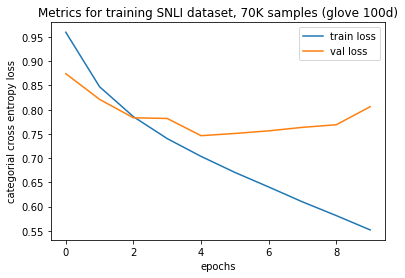

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove 100d)")
#history.history['loss']

In [94]:
model.load_weights(checkpoint_filepath)
model.evaluate(val_dataset)

468/468 [==============================] - 40s 85ms/step - loss: 0.7687 - accuracy: 0.6780


[0.7687164545059204, 0.6780181527137756]

#### Alternate
Trying the code from [here](https://github.com/songyang0716/NLP/blob/master/natural_language_inference/sentence_encoding_RNN/model.py)
and [concatenate lstm stackoverflow](https://stackoverflow.com/questions/53956998/how-can-i-concatenate-two-lstm-with-keras)

In [174]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)

inp1 = keras.Input(shape=(None,))
inp2 = keras.Input(shape=(None,))
x_hyp = embedding_layer(inp1)
x_evi = embedding_layer(inp2)

hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_hyp)
hyp_evi = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_evi)
w = keras.layers.concatenate([hyp_lstm, hyp_evi], axis = 1)

x3 = tf.keras.layers.Dense(16, activation='relu')(w)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model1 = keras.Model(inputs=[inp1, inp2], outputs=output)
model1.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1645200     input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 200)          160800      embedding_1[7][0]          

In [140]:
print(hyp_tokens.shape)
print(evi_tokens.shape)

(100000, 84)
(100000, 46)


In [143]:
from sklearn.model_selection import train_test_split
input_tensor_train_h, input_tensor_val_h, input_tensor_train_e, input_tensor_val_e, target_tensor_train, target_tensor_val = train_test_split(hyp_tokens, evi_tokens, train_labels, test_size=0.3)


NameError: name 'evi_tokens' is not defined

In [129]:
print(input_tensor_train_h.shape)
print(input_tensor_val_h.shape)
print(input_tensor_train_e.shape)
print(input_tensor_val_e.shape)
print(target_tensor_train.shape)
print(target_tensor_val.shape)

(70000, 84)
(30000, 84)
(70000, 46)
(30000, 46)
(70000, 3)
(30000, 3)


In [159]:
# BUFFER_SIZE = 32000
# BATCH_SIZE = 64
# train_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_train_h, 'input_7': input_tensor_train_e}, target_tensor_train))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# val_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_val_h, 'input_7': input_tensor_val_e}, target_tensor_val))
# val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [166]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
dataset_12 = tf.data.Dataset.from_tensor_slices((input_tensor_train_h, input_tensor_train_e))
dataset_label = tf.data.Dataset.from_tensor_slices(target_tensor_train)

train_dataset = tf.data.Dataset.zip((dataset_12, dataset_label))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset_12_val = tf.data.Dataset.from_tensor_slices((input_tensor_val_h, input_tensor_val_e))
dataset_label_val = tf.data.Dataset.from_tensor_slices(target_tensor_val)

val_dataset = tf.data.Dataset.zip((dataset_12_val, dataset_label_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [171]:
for t in train_dataset.take(1):
    print(len(t))
    print(t[0][1])
    print(t[1])

2
tf.Tensor(
[[   3    2   15 ...    0    0    0]
 [   3    2  133 ...    0    0    0]
 [   3  130 5299 ...    0    0    0]
 ...
 [   3    6    9 ...    0    0    0]
 [   3    2   29 ...    0    0    0]
 [   3  946   12 ...    0    0    0]], shape=(64, 46), dtype=int32)
tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.

In [156]:
checkpoint_filepath = 'tmp/checkpoint_bowman_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [143]:
ls tmp

checkpoint                      checkpoint_bowman.data-00000-of-00001
checkpoint.data-00000-of-00001  checkpoint_bowman.index
checkpoint.index


This is what we want the datasets to look like

`<BatchDataset shapes: (((64, 84), (64, 62)), (64, 3)), types: ((tf.int32, tf.int32), tf.float64)>`

In [184]:
train_dataset

<BatchDataset shapes: (((4, 55), (4, 55)), (4, 3)), types: ((tf.int64, tf.int64), tf.int32)>

In [157]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1645200     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 200)          160800      embedding_1[5][0]          

In [185]:
#since we are creating variables in the first call, we need to set this parameter, to run functions eagerly
tf.config.run_functions_eagerly(True)
history1 = model1.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

NameError: name 'stop_early' is not defined